In [12]:
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteOp, FiniteVec, multiply, inner, SpVec, CombVec
from jaxrk.kern import (GaussianKernel, SplitDimsKernel, PeriodicKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from sklearn.datasets import make_moons

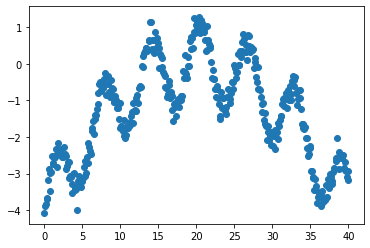

In [13]:
x = np.linspace(0, 40, 400).reshape((-1, 1))
y = np.sin(x) -(0.1*(x-20))**2 + randn(len(x)).reshape((-1, 1)) * 0.2
out_kern = GaussianKernel(0.5)

pl.scatter(x.T, y.T)

In [14]:
spv = SpVec(out_kern, np.hstack((x, y)), np.array([len(x)]), use_subtrajectories = True)

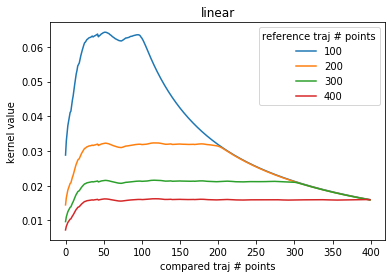

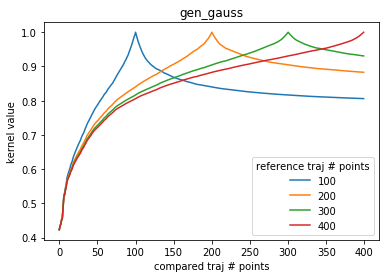

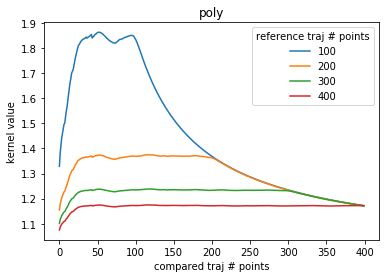

In [15]:
for dist in ("linear", "gen_gauss", "poly"):
    spv.use_inner = dist
    inn = spv.inner()
    pl.figure()
    for i in range(100, 401, 100):
        pl.plot(inn[i], label=str(i))
    pl.legend(loc="best", title="reference traj # points")
    pl.title(dist)
    pl.xlabel("compared traj # points")
    pl.ylabel("kernel value")

In [16]:
def plot_pred(mean_var, x, y, points_per_split = 1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)
        
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[:200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split:].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)


In [86]:
refervec = FiniteVec(out_kern, np.linspace(y.min() - 4, y.max() + 4, 6000)[:, None])
invec_gg = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="gen_gauss")
invec_lin = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="linear")
invec_pol = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="poly")
outvec = FiniteVec(out_kern, y[1:])

Text(0.5, 1.0, 'Generalized gaussian kernel on process embeddings')

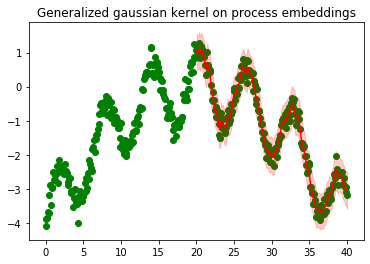

In [87]:
cd_gg = Cmo(invec_gg, outvec)
mean_var_gg = np.array(multiply(cd_gg, invec_gg).normalized().get_mean_var()).T
plot_pred(mean_var_gg[199:], x, y)
pl.title("Generalized gaussian kernel on process embeddings")

In [92]:
invec_gg.inspace_points.shape

(399, 2)

In [90]:
invec_inf = SpVec(out_kern, np.hstack((x[:200], y[:200])), np.array([200]), use_subtrajectories = False, use_inner="gen_gauss")
multiply(cd_gg, invec_gg).prefactors, multiply(cd_gg, invec_inf).point_representant()

(DeviceArray([9.7021031e-01, 2.2069737e-02, 6.0540647e-04, ...,
              1.2607238e-01, 2.4042103e-01, 4.6217641e-01], dtype=float32),
 DeviceArray([-1.3468388], dtype=float32))

In [149]:
from tqdm import tqdm
invec_inf = SpVec(out_kern, np.hstack((x[:200], y[:200])), np.array([200]), use_subtrajectories = False, use_inner="gen_gauss")
inc = (current_hist.inspace_points[1:, 0] -  current_hist.inspace_points[:-1, 0]).mean()
rval = []
for j in range(1):
    current_hist = invec_inf
    rval.append([])
    print(j)
    for i in tqdm(range(1, 200)):
        rval[-1].append(multiply(cd_gg, current_hist).point_representant())
        new_point = np.array((current_hist.inspace_points[-1, 0] + inc, rval[-1][-1][-1]))
        current_hist = SpVec(out_kern, np.vstack([current_hist.inspace_points, new_point]), np.array([len(current_hist.inspace_points) + 1]), use_subtrajectories = False, use_inner="gen_gauss")




  0%|          | 0/199 [00:00<?, ?it/s]0



  1%|          | 1/199 [00:00<02:35,  1.27it/s]


  1%|          | 2/199 [00:01<02:42,  1.21it/s]


  2%|▏         | 3/199 [00:04<04:35,  1.40s/it]


  2%|▏         | 4/199 [00:06<05:32,  1.70s/it]


  3%|▎         | 5/199 [00:09<06:22,  1.97s/it]


  3%|▎         | 6/199 [00:11<06:20,  1.97s/it]


  4%|▎         | 7/199 [00:12<05:55,  1.85s/it]


  4%|▍         | 8/199 [00:15<06:13,  1.95s/it]


  5%|▍         | 9/199 [00:17<06:05,  1.92s/it]


  5%|▌         | 10/199 [00:18<05:59,  1.90s/it]


  6%|▌         | 11/199 [00:21<06:39,  2.13s/it]


  6%|▌         | 12/199 [00:23<06:16,  2.01s/it]


  7%|▋         | 13/199 [00:24<05:46,  1.86s/it]


  7%|▋         | 14/199 [00:26<05:26,  1.76s/it]


  8%|▊         | 15/199 [00:28<05:22,  1.75s/it]


  8%|▊         | 16/199 [00:29<05:15,  1.72s/it]


  9%|▊         | 17/199 [00:31<05:06,  1.69s/it]


  9%|▉         | 18/199 [00:33<05:30,  1.82s/it]


 10%|▉         | 19/199 [00:35<05:42,  1.90s

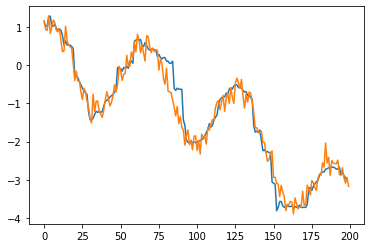

In [153]:
rv = np.array(rval).squeeze()
pl.plot(rv)
#pl.fill_between(range(300), rv.mean(0)-rv.std(0), rv.mean(0)+rv.std(0), alpha=0.5)
pl.plot(y.flatten()[200:])

In [96]:
multiply(cd_gg, invec_inf).prefactors

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan

In [124]:
g_mix = cd_gg.inp_feat.k(cd_gg.inp_feat.inspace_points, invec_inf.inspace_points)
g_op = cd_gg.inp_feat.k(cd_gg.inp_feat.inspace_points)
g_iv = cd_gg.inp_feat.k(invec_inf.inspace_points)

In [127]:
for g in g_mix, g_op, g_iv:
    print(np.any(np.isinf(g_mix)), np.any(np.isnan(g_mix)))

False False
False False
False False


In [142]:
#efficient
from tqdm import tqdm

boundary = 200
invec_inf = SpVec(out_kern, np.hstack((x[:boundary], y[:boundary])), np.array([boundary]), use_subtrajectories = False, use_inner="gen_gauss")
inc = (current_hist.inspace_points[1:, 0] -  current_hist.inspace_points[:-1, 0]).mean()

start_emb = multiply(cd_gg, invec_inf)
k = boundary
rval = []
for j in range(2):
    current_hist = invec_inf
    rval.append([])
    print(j)
    emb = start_emb
    cur_idx = invec_inf.inspace_points[-1, 0]
    
    for i in (range(300)):
        rval[-1].append(emb.point_representant())
        cur_idx = cur_idx + inc
        new_point = np.array((cur_idx, rval[-1][-1][-1])).reshape(1,-1)
        upd = multiply(cd_gg, SpVec(out_kern, new_point.reshape((1, -1)), np.array([1]), use_subtrajectories = False, use_inner="gen_gauss"))
        emb = emb.updated((emb.prefactors * k + upd.prefactors)/(k + 1))
        k = k + 1

0
1


In [147]:
a = start_emb
b = multiply(cd_gg, SpVec(out_kern, np.hstack((x[:200], y[:200])), np.array([200]), use_subtrajectories = False, use_inner="gen_gauss"))

In [148]:
a.prefactors - b.prefactors

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [152]:
rv

DeviceArray([ 1.1293497 ,  1.022217  ,  1.022217  ,  1.2825487 ,
              1.2825487 ,  1.022217  ,  1.022217  ,  1.0687246 ,
              0.95259964,  0.9347871 ,  0.95259964,  0.91347504,
              0.7731553 ,  0.52459663,  0.63567156,  0.528111  ,
              0.528111  ,  0.52459663,  0.4893118 ,  0.43543983,
             -0.2600342 , -0.28101864, -0.32280323, -0.43044457,
             -0.5129037 , -0.59998316, -0.6632598 , -0.7307712 ,
             -0.76888025, -1.2164022 , -1.4210323 , -1.4348704 ,
             -1.3933318 , -1.2925441 , -1.2058874 , -1.2378594 ,
             -1.2058874 , -1.2423487 , -1.2063055 , -1.0683762 ,
             -0.94584066, -0.9249024 , -0.88463837, -0.8325269 ,
             -0.801945  , -0.76888025, -0.7009595 , -0.63851917,
             -0.05973113, -0.08083397, -0.08820716, -0.15825988,
             -0.05973113, -0.08083397, -0.02652372, -0.08083397,
              0.10613   ,  0.10613   ,  0.04876605,  0.62396693,
              0.6587101 ,

Text(0.5, 1.0, 'Linear kernel on process embeddings')

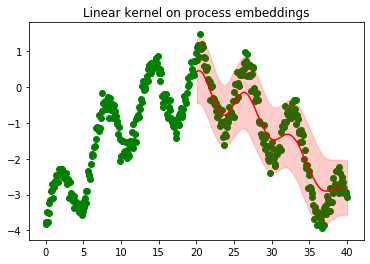

In [57]:
cd_lin = Cdo(invec_lin, outvec, refervec)
mean_var_lin = np.array(multiply(cd_lin, invec_lin).normalized().get_mean_var()).T
plot_pred(mean_var_lin[199:], x, y)
pl.title("Linear kernel on process embeddings")

Text(0.5, 1.0, 'Polynomial kernel on process embeddings')

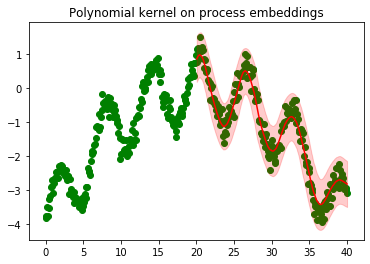

In [48]:
cd_pol = Cdo(invec_pol, outvec, refervec)
mean_var_pol = np.array(multiply(cd_pol, invec_pol).normalized().get_mean_var()).T
plot_pred(mean_var_pol[199:], x, y)
pl.title("Polynomial kernel on process embeddings")